In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

In [2]:
df = pd.read_csv('Ecommerce_Fraud_Detection.csv')
df

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299690,299691,6000,996,45,27.93,34.07,ES,ES,web,grocery,0,1,1,0,2024-09-29T04:40:54Z,218.55,0
299691,299692,6000,996,45,27.93,68.56,ES,ES,app,travel,0,1,1,1,2024-10-03T08:49:02Z,185.55,0
299692,299693,6000,996,45,27.93,25.02,ES,ES,app,fashion,0,1,1,1,2024-10-26T07:40:38Z,33.50,0
299693,299694,6000,996,45,27.93,23.92,ES,ES,web,gaming,0,0,0,0,2024-10-27T09:31:56Z,71.75,0


Step 1. Handle Missings Value

In [3]:
df.isnull()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299690,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
299691,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
299692,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
299693,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [4]:
df.fillna(df.mean, inplace= True)
df.dropna(inplace= True)

Step 2. Remove Duplicates

In [5]:
df.drop_duplicates(inplace= True)

Step 3. Fix Data Type

In [6]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'], errors= 'coerce')

# Check if any values became 'NaT' (Not a Time)
invalid_dates =df['transaction_time'].isna().sum()
if invalid_dates > 0:
    print(f"Waring :{invalid_dates} rows could not be parsed and are now NaT.")

In [7]:
def apply_missing_value_strategy(df):
    # Create a copy to avoid setting with copy waring
    df = df.copy()

    # 1. Amount mandontary remove missing value
    df = df.dropna(subset=['amount'])

    # 2. 'avg_amt_user': Replace with user's typical spend
    
    if 'user_id' in df.columns:
        df['avg_amount_user'] = df.groupby('user_id')['avg_amount_user'].transform(lambda x: x.fillna(x.mean()))

        # 3. 'shipping_distanse_km': Replace with median or 0 (digital)
    # Note: Using .median() across the whole column for non-digital items
    median_val = df['shipping_distance_km'].median()

    # Logic: If digital, fill with 0. Otherwise, fill with median.
    # Assuming 'is_digital' is a boolean or 1/0 column

    df['shipping_distance_km'] = np.where(
        df['merchant_category'] == True,
        df['shipping_distance_km'].fillna(0),
        df['shipping_distance_km'].fillna(median_val)
    )

    # 4. 'Security flags': Label as "Not Checked"
    df['three_ds_flag'] = df['three_ds_flag'].fillna('Not Checked')

    return df
apply_missing_value_strategy(df)

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06 04:09:39+00:00,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09 20:13:47+00:00,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12 06:20:11+00:00,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15 17:00:04+00:00,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17 01:27:31+00:00,935.28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299690,299691,6000,996,45,27.93,34.07,ES,ES,web,grocery,0,1,1,0,2024-09-29 04:40:54+00:00,218.55,0
299691,299692,6000,996,45,27.93,68.56,ES,ES,app,travel,0,1,1,1,2024-10-03 08:49:02+00:00,185.55,0
299692,299693,6000,996,45,27.93,25.02,ES,ES,app,fashion,0,1,1,1,2024-10-26 07:40:38+00:00,33.50,0
299693,299694,6000,996,45,27.93,23.92,ES,ES,web,gaming,0,0,0,0,2024-10-27 09:31:56+00:00,71.75,0


In [8]:
def standardize_data(df):
    df = df.copy()

    # 1. Convert inconsistent values (Yes/Y/1 -> Yes, No/N/0 -> No)
    bool_map = {
        'Yes': "Yes",'Y': "Yes",'1':"Yes", 1: "Yes",
        "No": "No",'N': 'No','0': "No", 0: 'No'
    }
    # Apply to columns that should be Yes/No (Example: 'is_member')
    if 'is_fraud' in df.columns:
        df['is_fraud'] = df['is_fraud'].map(bool_map)

    # 2. Standardize country names (Title Case & strip spaces)
    if 'country' in df.columns:
        df['country'] = df['country'].astype(str).str.strip().str.title()

    # 3. Fix spelling/format in categories
    if 'category' in df.columns:
        df['category'] = df['category'].astype(str).str.strip().str.title()

    return df
standardize_data(df)    


,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,Fr,FR,web,travel,0,1,1,1,2024-01-06 04:09:39+00:00,370.95,No
1,2,1,141,47,147.93,107.90,Fr,FR,web,travel,0,0,0,0,2024-01-09 20:13:47+00:00,149.62,No
2,3,1,141,47,147.93,92.36,Fr,FR,app,travel,1,1,1,1,2024-01-12 06:20:11+00:00,164.08,No
3,4,1,141,47,147.93,112.47,Fr,FR,web,fashion,0,1,1,1,2024-01-15 17:00:04+00:00,397.40,No
4,5,1,141,47,147.93,132.91,Fr,US,web,electronics,0,1,1,1,2024-01-17 01:27:31+00:00,935.28,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299690,299691,6000,996,45,27.93,34.07,Es,ES,web,grocery,0,1,1,0,2024-09-29 04:40:54+00:00,218.55,No
299691,299692,6000,996,45,27.93,68.56,Es,ES,app,travel,0,1,1,1,2024-10-03 08:49:02+00:00,185.55,No
299692,299693,6000,996,45,27.93,25.02,Es,ES,app,fashion,0,1,1,1,2024-10-26 07:40:38+00:00,33.50,No
299693,299694,6000,996,45,27.93,23.92,Es,ES,web,gaming,0,0,0,0,2024-10-27 09:31:56+00:00,71.75,No


Step 4. Remove Outliers

I checked the outliers in the amount column, and a total of 26711 outliers were detected. I then applied a log transformation to it, and its value became 0.

Total Outliers detected: 26711
------------------------------
Top 5 Highest Outliers:
144366    16994.74
144367    16979.92
10383     16597.07
144365    13123.83
144334    11115.55
Name: amount, dtype: float64

Top 5 Lowest Outliers:
290273    414.63
91237     414.63
273023    414.63
48054     414.64
296719    414.66
Name: amount, dtype: float64


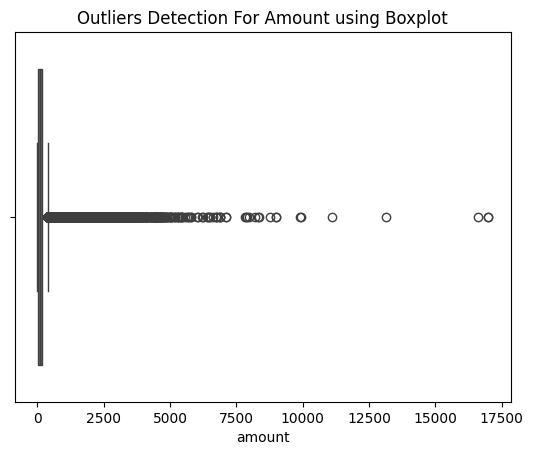

In [9]:
# Calculate Ouartiles
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

# Define Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df[(df['amount'] < lower_bound) | (df['amount'] > upper_bound)]

# Filter them out keep only normal Data
df_clean = df[(df['amount'] >= lower_bound) & (df['amount'] <= upper_bound)]

# Assuming you have already calculated lower_bound and upper_bound

print(f"Total Outliers detected: {len(outliers)}")
print("-" * 30)
print("Top 5 Highest Outliers:")
print(outliers['amount'].sort_values(ascending=False).head())

print("\nTop 5 Lowest Outliers:")
print(outliers['amount'].sort_values(ascending=True).head())

sns.boxplot(x = df['amount'])
plt.title("Outliers Detection For Amount using Boxplot")
plt.show()

In [10]:
df['amount_log'] = np.log1p(df['amount'])
print("Log Transformation Value:")
print(df['amount_log'].head())

Log Transformation Value:
0    4.451436
1    4.690430
2    4.536463
3    4.731538
4    4.897168
Name: amount_log, dtype: float64


Final Outliers: 0


Text(0.5, 1.0, 'Final Data Distribution')

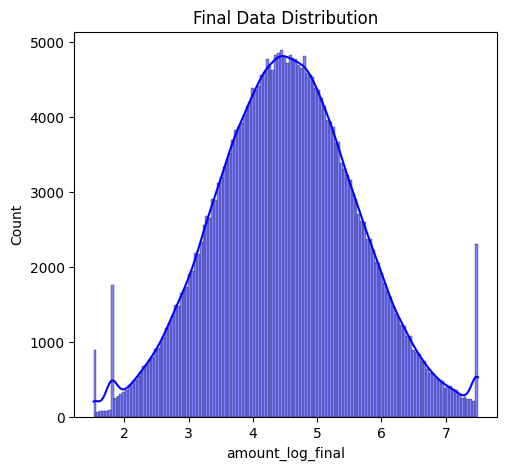

In [11]:
# Calculate Outliers
Q1_log = df['amount_log'].quantile(0.25)
Q3_log = df['amount_log'].quantile(0.75)
IQR_log = Q3_log - Q1_log

# Define bonds identify Ouliers
lower_limit = Q1_log - 1.5 * IQR_log
upper_limit= Q3_log + 1.5 * IQR_log

# Apply the Capping
df['amount_log_final'] = df['amount_log'].clip(lower= lower_limit, upper= upper_limit)

final_outliers = df[(df['amount_log_final'] < lower_limit) | (df['amount_log_final'] > upper_limit)]
print(f"Final Outliers: {len(final_outliers)}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['amount_log_final'], kde=True, color='blue')
plt.title('Final Data Distribution')

Remove outlier in Shipping Distance Km

Total Outliers detected: 20312
------------------------------
Top 5 Highest Outliers:
204146    3748.56
140209    3745.96
114716    3744.74
245401    3742.57
156488    3741.74
Name: shipping_distance_km, dtype: float64

Top 5 Lowest Outliers:
94457     818.16
200205    818.22
110217    818.23
225047    818.26
52005     818.30
Name: shipping_distance_km, dtype: float64


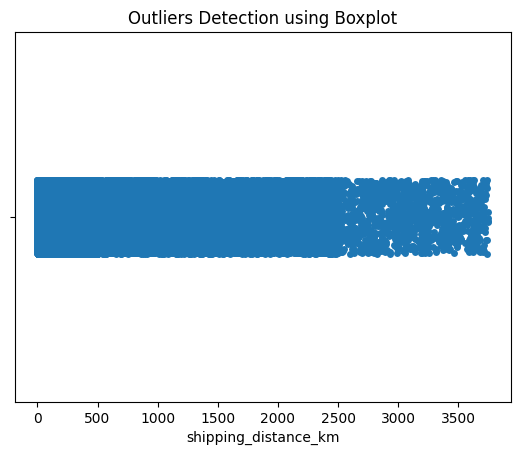

In [12]:
# Calculate Ouartiles
Q1 = df['shipping_distance_km'].quantile(0.25)
Q3 = df['shipping_distance_km'].quantile(0.75)
IQR = Q3 - Q1

# Define Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify Outliers
outliers = df[(df['shipping_distance_km'] < lower_bound) | (df['shipping_distance_km'] > upper_bound)]

# Filter them out keep only normal Data
df_clean = df[(df['shipping_distance_km'] >= lower_bound) & (df['shipping_distance_km'] <= upper_bound)]

# Assuming you have already calculated lower_bound and upper_bound

print(f"Total Outliers detected: {len(outliers)}")
print("-" * 30)
print("Top 5 Highest Outliers:")
print(outliers['shipping_distance_km'].sort_values(ascending=False).head())

print("\nTop 5 Lowest Outliers:")
print(outliers['shipping_distance_km'].sort_values(ascending=True).head())

sns.stripplot(x = df['shipping_distance_km'])
plt.title("Outliers Detection using Boxplot")
plt.show()

In [13]:
df['shipping_distance_km_log'] = np.log1p(df['shipping_distance_km'])
print("Log Transformation Value:")
print(df['shipping_distance_km_log'].head())

Log Transformation Value:
0    5.918759
1    5.014760
2    5.106430
3    5.987457
4    6.841915
Name: shipping_distance_km_log, dtype: float64


Lower Limit: 3.2859831821297276, Upper Limit: 7.6549638311151025
Final Outliers in New Column: 0
Max value after capping: 7.6549638311151025


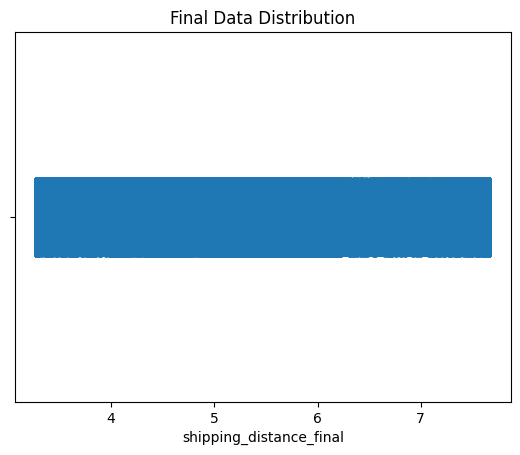

In [14]:
# 1. Calculate Outliers
Q1 = df['shipping_distance_km_log'].quantile(0.25)
Q3 = df['shipping_distance_km_log'].quantile(0.75)
IQR = Q3 - Q1

# 2. Limits Set
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# 3. Apply the clip for new column add.
df['shipping_distance_final'] = df['shipping_distance_km_log'].clip(lower=lower_limit, upper=upper_limit)

# 4. Final Outliers Check for New column.
final_outliers = ((df['shipping_distance_final'] < lower_limit) | (df['shipping_distance_final'] > upper_limit)).sum()

print(f"Lower Limit: {lower_limit}, Upper Limit: {upper_limit}")
print(f"Final Outliers in New Column: {final_outliers}")

# 5. Verification: 
print(f"Max value after capping: {df['shipping_distance_final'].max()}")

sns.stripplot(x = df['shipping_distance_final'])
plt.title('Final Data Distribution')
plt.show()

# EDA (Exploratory Data Analysis)

# 4.1 Fraud Distribution

--- Fraud Distrbution ---
Non Fraud: 0.00%
Fraud : 1.00%
Business Insight: Imbalance is expected as fraud is rare.


C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\3849795380.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'is_fraud', data = df, palette=['#4CAF50', '#FF5252'])


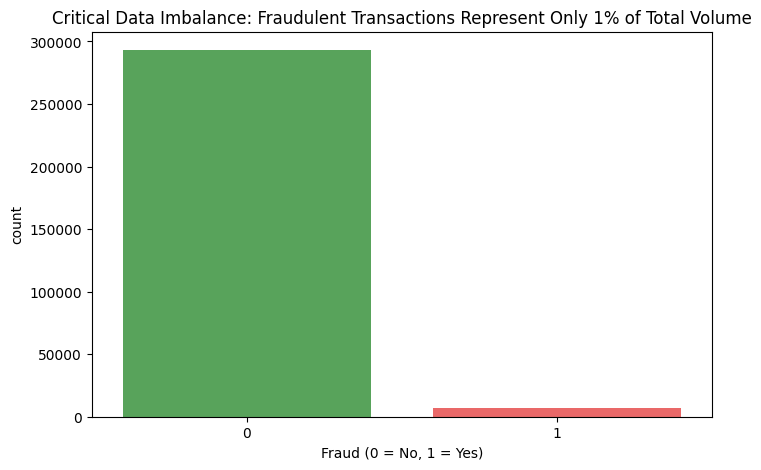

In [15]:
# Fraud Distribution
def Analyze_fraud_distribution(df):
    if 'is_fraud' in df.columns:
        counts = df['is_fraud'].value_counts(normalize= True) * 100
        print("--- Fraud Distrbution ---")
        print(f"Non Fraud: {counts.get("NO", 0):.2f}%")
        print(f"Fraud : {counts.get("YES", 1):.2f}%")
        print("Business Insight: Imbalance is expected as fraud is rare.")
    else:
        print("Error: 'is_fraud' column not found for distribution analysis.")
Analyze_fraud_distribution(df)

plt.figure(figsize=(8, 5))
sns.countplot(x = 'is_fraud', data = df, palette=['#4CAF50', '#FF5252'])
plt.title("Critical Data Imbalance: Fraudulent Transactions Represent Only 1% of Total Volume")
plt.xlabel("Fraud (0 = No, 1 = Yes)")
plt.show()

# 4.2 Transaction Behavior Analysis

--- 4.2 Transaction Behavior Analysis ---

Fraud Rate by Amount Level:
amt_bucket
Low       2.458385
Medium    1.308295
High      2.852109
Name: fraud_numeric, dtype: float64


C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\4022373281.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('amt_bucket')['fraud_numeric'].mean() * 100)
C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\4022373281.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_bucket = df.groupby('amt_bucket')['fraud_numeric'].mean().reset_index()
C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\4022373281.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn

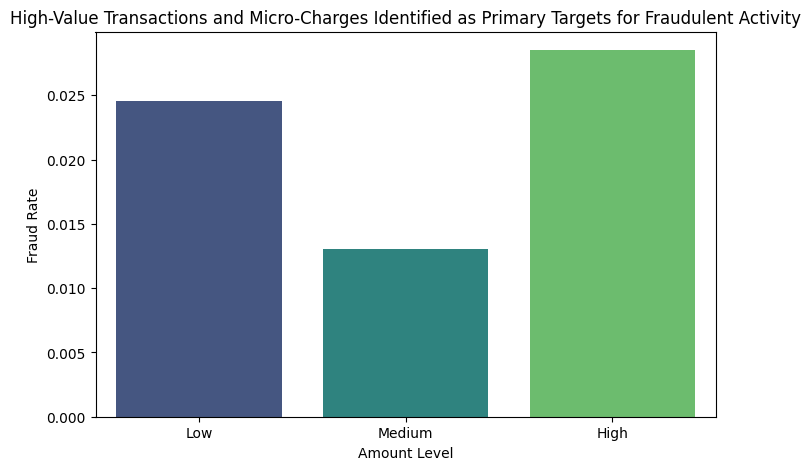

In [16]:

def analyze_transaction_behavior(df):
    print("--- 4.2 Transaction Behavior Analysis ---")

    # 1. Create 'Amount Buckets' (Low, Medium, High)
    # This splits your 'amt' column into 3 equal-sized groups
    df['amt_bucket'] = pd.qcut(df['amount'], q=3, labels=['Low', 'Medium', 'High'])

    # 2. Calculate Fraud Rate for each Bucket
    fraud_col = 'is_fraud' 
    
    # We convert the fraud column to numbers (1 for Yes, 0 for No) to get the average
    df['fraud_numeric'] = df[fraud_col].apply(lambda x: 1 if str(x) in ['Yes', '1', 'True'] else 0)
    
    print("\nFraud Rate by Amount Level:")
    print(df.groupby('amt_bucket')['fraud_numeric'].mean() * 100)

    # 3. Compare Current Amount vs User's Average
    # We calculate how many times larger the current transaction is compared to their normal
    if 'avg_amt_user' in df.columns:
        df['spend_ratio'] = df['amount'] / df['avg_amount_user']
        
        print("\nSpike Analysis (Current Amt / Avg User Amt):")
        # Show the average 'spike' for Non-Fraud vs Fraud
        print(df.groupby(fraud_col)['spend_ratio'].mean())
        print("\nInsight: If the Fraud number is higher, it means fraudsters spend unusually high amounts.")

# --- How to run it ---
analyze_transaction_behavior(df)

fraud_rate_bucket = df.groupby('amt_bucket')['fraud_numeric'].mean().reset_index()

plt.figure(figsize= (8,5))
sns.barplot(x = 'amt_bucket', y = 'fraud_numeric', data= fraud_rate_bucket, palette='viridis')
plt.title('High-Value Transactions and Micro-Charges Identified as Primary Targets for Fraudulent Activity')
plt.ylabel('Fraud Rate')
plt.xlabel('Amount Level')
plt.show()

--- Shipping Distance Analysis ---

Fraud Rate by Shipping Distance:
shipping_type
Local            0.964285
Long Distance    3.448276
Name: fraud_numeric, dtype: float64

Insight: If 'Long Distance' has a higher percentage, fraudsters are ordering items to faraway places.


C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\634368251.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('shipping_type')['fraud_numeric'].mean() * 100)
C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\634368251.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shipping_risk = df.groupby('shipping_type')['fraud_numeric'].mean().reset_index()
C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\634368251.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns

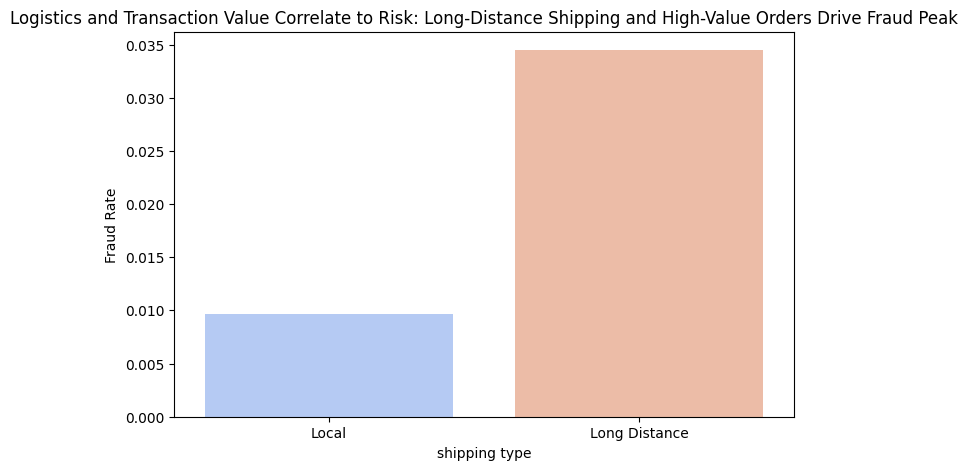

In [17]:
def analyze_shipping_risk(df):
    print("--- Shipping Distance Analysis ---")

    # 1. Create 'Local' vs 'Long Distance' Groups
    # We split the data into 2 equal parts: the lower half is 'Local', upper half is 'Long Distance'
    try:
        df['shipping_type'] = pd.qcut(df['shipping_distance_km'], q=2, labels=['Local', 'Long Distance'])
    except ValueError:
        # Fallback if there isn't enough data variance
        df['shipping_type'] = 'Unknown'

    # 2. Calculate Fraud Rate for each Group
    # REPLACE 'is_fraud' with your actual fraud column name
    fraud_col = 'is_fraud'
    
    # Convert fraud column to numbers (1 for Yes, 0 for No) if needed
    # (If you already ran the previous step, this 'fraud_numeric' column might already exist)
    if 'fraud_numeric' not in df.columns:
        df['fraud_numeric'] = df[fraud_col].apply(lambda x: 1 if str(x) in ['Yes', '1', 'True'] else 0)

    print("\nFraud Rate by Shipping Distance:")
    print(df.groupby('shipping_type')['fraud_numeric'].mean() * 100)
    
    print("\nInsight: If 'Long Distance' has a higher percentage, fraudsters are ordering items to faraway places.")

# --- How to run it ---
analyze_shipping_risk(df)

shipping_risk = df.groupby('shipping_type')['fraud_numeric'].mean().reset_index()

plt.figure(figsize= (8, 5))
sns.barplot(x = 'shipping_type', y = 'fraud_numeric', data= shipping_risk, palette= 'coolwarm')
plt.title('Logistics and Transaction Value Correlate to Risk: Long-Distance Shipping and High-Value Orders Drive Fraud Peak')
plt.ylabel('Fraud Rate')
plt.xlabel('shipping type')
plt.show()

--- Time Analysis: Business Hours vs Late Night ---

Fraud Rate by Time of Day:
time_of_day
Business Hours    2.160994
Late Night        2.259751
Name: fraud_numeric, dtype: float64

Insight: A higher rate in 'Late Night' suggests automated bots or international fraudsters.


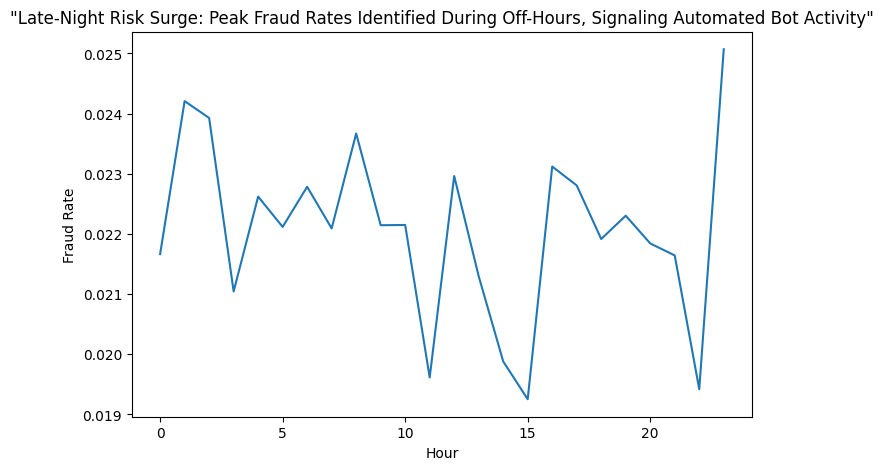

In [18]:
def analyze_time_patterns(df):
    print("--- Time Analysis: Business Hours vs Late Night ---")

    # 1. Convert your time column to DateTime objects
    # REPLACE 'trans_time' with your actual time column (e.g., 'trans_date_trans_time', 'timestamp')
    time_col = 'transaction_time' 
    
    # This line ensures Python understands the dates/times correctly
    df[time_col] = pd.to_datetime(df[time_col])

    # 2. Extract the Hour (0 to 23)
    df['hour'] = df[time_col].dt.hour

    # 3. Create Categories: 'Business Hours' (9 AM - 9 PM) vs 'Late Night' (Everything else)
    # logic: if hour is between 9 and 21 (9pm), it's Business. Else, Late Night.
    df['time_of_day'] = df['hour'].apply(lambda x: 'Business Hours' if 9 <= x <= 21 else 'Late Night')

    # 4. Calculate Fraud Rate by Time Category
    # We use the same 'fraud_numeric' concept as before
    fraud_col = 'is_fraud' # Update this if your column name is different
    
    if 'fraud_numeric' not in df.columns:
         df['fraud_numeric'] = df[fraud_col].apply(lambda x: 1 if str(x) in ['Yes', '1', 'True'] else 0)

    print("\nFraud Rate by Time of Day:")
    print(df.groupby('time_of_day')['fraud_numeric'].mean() * 100)
    
    print("\nInsight: A higher rate in 'Late Night' suggests automated bots or international fraudsters.")

# --- How to run it ---
analyze_time_patterns(df)

time_analysis = df.groupby('hour')['fraud_numeric'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(x = 'hour', y = 'fraud_numeric', data= time_analysis)
plt.title('"Late-Night Risk Surge: Peak Fraud Rates Identified During Off-Hours, Signaling Automated Bot Activity"')
plt.ylabel('Fraud Rate')
plt.xlabel('Hour')
plt.show()

Final Business Recommendation (Strategy)
Based on these results, the business should implement this new system:

The "Triple Threat" Rule: If a transaction involves a high amount, a long-distance address, and occurs late at night, it should be immediately declined without question or held for manual review.

Targeted Friction: Implement Video KYC or mandatory phone call verification for late-night transactions, as there is a risk of bot activity during these hours.

# 4.3 Security Checks Analysis

--- Security Checks Analysis ---

Fraud Rate by AVS (avs_match):
avs_match
0    9.666124
1    0.764103
Name: fraud_numeric, dtype: float64

Fraud Rate by CVV (cvv_result):
cvv_result
0    10.605823
1     0.974492
Name: fraud_numeric, dtype: float64

Fraud Rate by 3D Secure (three_ds_flag):
three_ds_flag
0    6.752068
1    0.958165
Name: fraud_numeric, dtype: float64

Insight: You expect to see much higher fraud rates when these checks 'Fail' or are 'Disabled'.


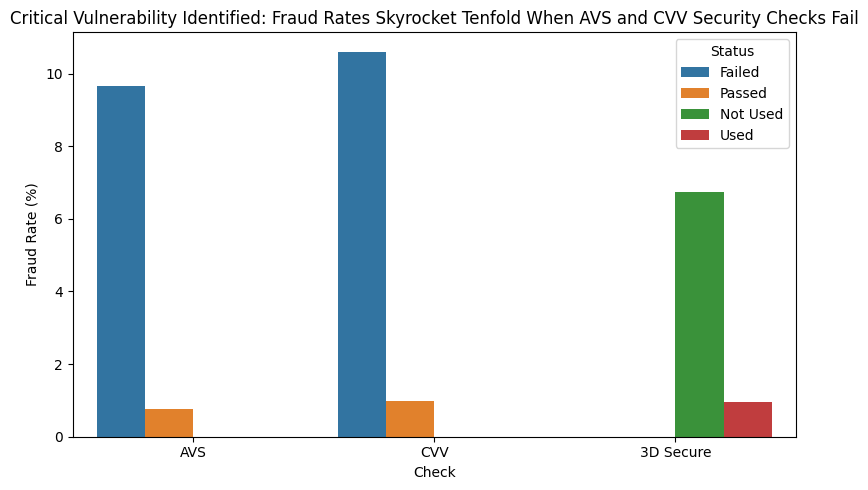

In [19]:
def analyze_security_checks(df):
    print("--- Security Checks Analysis ---")

    # 1. Setup: Define your actual column names here
    avs_col = 'avs_match'  # avs: address Match
    cvv_col = 'cvv_result'    # cvv: cvv check
    three_col = 'three_ds_flag' # 3d_secure: verified by visa
    
    # Define our Fraud Column (make sure this matches your data)
    fraud_col = 'is_fraud'

    # Ensure we have the numeric fraud column for calculations
    if 'fraud_numeric' not in df.columns:
        df['fraud_numeric'] = df[fraud_col].apply(lambda x: 1 if str(x) in ['Yes', '1', 'True'] else 0)

    # 2. Analyze AVS (Address Verification)
    if avs_col in df.columns:
        print(f"\nFraud Rate by AVS ({avs_col}):")
        print(df.groupby(avs_col)['fraud_numeric'].mean() * 100)
    else:
        print(f"\nSkipping AVS: Column '{avs_col}' not found.")

    # 3. Analyze CVV (Card Security Code)
    if cvv_col in df.columns:
        print(f"\nFraud Rate by CVV ({cvv_col}):")
        print(df.groupby(cvv_col)['fraud_numeric'].mean() * 100)
    else:
        print(f"\nSkipping CVV: Column '{cvv_col}' not found.")

    # 4. Analyze 3DS (3D Secure / OTP)
    if three_col in df.columns:
        print(f"\nFraud Rate by 3D Secure ({three_col}):")
        print(df.groupby(three_col)['fraud_numeric'].mean() * 100)
    else:
        print(f"\nSkipping 3DS: Column '{three_col}' not found.")

    print("\nInsight: You expect to see much higher fraud rates when these checks 'Fail' or are 'Disabled'.")

# --- How to run it ---
analyze_security_checks(df)

df_grouped = pd.DataFrame({
    "Check": ['AVS','AVS','CVV','CVV','3D Secure','3D Secure'],
    "Status": ['Failed','Passed','Failed','Passed','Not Used','Used'],
    "Fraud_Rate": [9.666124, 0.764103, 10.605823, 0.974492, 6.752068, 0.958165]
})

plt.figure(figsize=(8,5))
sns.barplot(x= "Check", y= "Fraud_Rate", hue= "Status", data= df_grouped)
plt.title("Critical Vulnerability Identified: Fraud Rates Skyrocket Tenfold When AVS and CVV Security Checks Fail")
plt.ylabel("Fraud Rate (%)")
plt.tight_layout()
plt.show()

In [20]:
def analyze_fraud_intersections(df):

    # 1. define "High Amount" threshold 

    high_amt_threshold = df['amount'].quantile(0.90)

    # Define the Intersection
    # Intersection 1: High amount + No 3ds 
    mask1 = (df['amount'] >= high_amt_threshold) & (df['three_ds_flag'] == 0)

    # Intersection 2: shipping type (e.g long distance) + cvv failed
    mask2 = (df['shipping_type'] == 'Long Distance') & (df['cvv_result'] == 0)

    # Intersection 3: Late Night (e.g 11 PM to 4 AM) + weak security
    mask3 = (df['hour'].isin([23,0,1,2,3,4])) & (df['three_ds_flag'])


    # calculate fraud rates for each
    results= []
    for name, mask in zip(['High Amt + No 3DS', 'Long Ship + CVV Fail','Late Night + Weak Security'],
                          [mask1, mask2, mask3]):
        subset = df[mask]
        fraud_rate = subset['is_fraud'].mean() * 100 if len(subset) > 0 else 0
        results.append({
            "Intersection": name,
            "Count": len(subset),
            "Fraud Rate (%)": round(fraud_rate, 2)
        })
    return pd.DataFrame(results)    

analyze_fraud_intersections(df)

,Intersection,Count,Fraud Rate (%)
0,High Amt + No 3DS,7078,18.92
1,Long Ship + CVV Fail,20211,15.71
2,Late Night + Weak Security,58711,0.96


# Statistical Analysis 

In [21]:
def run_statistical_fraud_analysis(df):
    # 1. Secured vs Unsecured Analysis
    df['security_status'] = np.where(
        (df['three_ds_flag'] == 1) | (df['cvv_result'] == 1),
        'Secured',
        'Unsecured')
    
    security_stats = df.groupby('security_status')['is_fraud'].agg(['count','mean'])
    security_stats['mean'] = (security_stats['mean'] * 100).round(2)
    security_stats.columns = ['Total Transeactions', 'Fraud Rate (%)']


    # Normal vs Abnormal Amount Analysis

    Q1 = df['amount'].quantile(0.25)
    Q3 = df['amount'].quantile(0.95)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df['amount_type'] = np.where(
        (df['amount'] < lower_bound) | (df['amount'] > upper_bound),
        'Abnormal',
        'Normal'
    )

    amount_stats = df.groupby('amount_type')['is_fraud'].agg(['count', 'mean'])
    amount_stats['mean'] = (amount_stats['mean'] * 100).round(2)
    amount_stats.columns = ['Total Transaction', 'Fraud Rate (%)']

    return security_stats, amount_stats

run_statistical_fraud_analysis(df)


(                 Total Transeactions  Fraud Rate (%)
 security_status                                     
 Secured                       272125            1.08
 Unsecured                      27570           13.28,
              Total Transaction  Fraud Rate (%)
 amount_type                                   
 Abnormal                  3305           39.85
 Normal                  296390            1.79)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\1697048087.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'security_status', y= 'is_fraud', data= df, estimator=lambda x: sum(x)/len(x) * 100, palette= 'viridis')
C:\Users\Hp\AppData\Local\Temp\ipykernel_8224\1697048087.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'is_fraud', y = 'amount', data= df, palette= 'viridis')


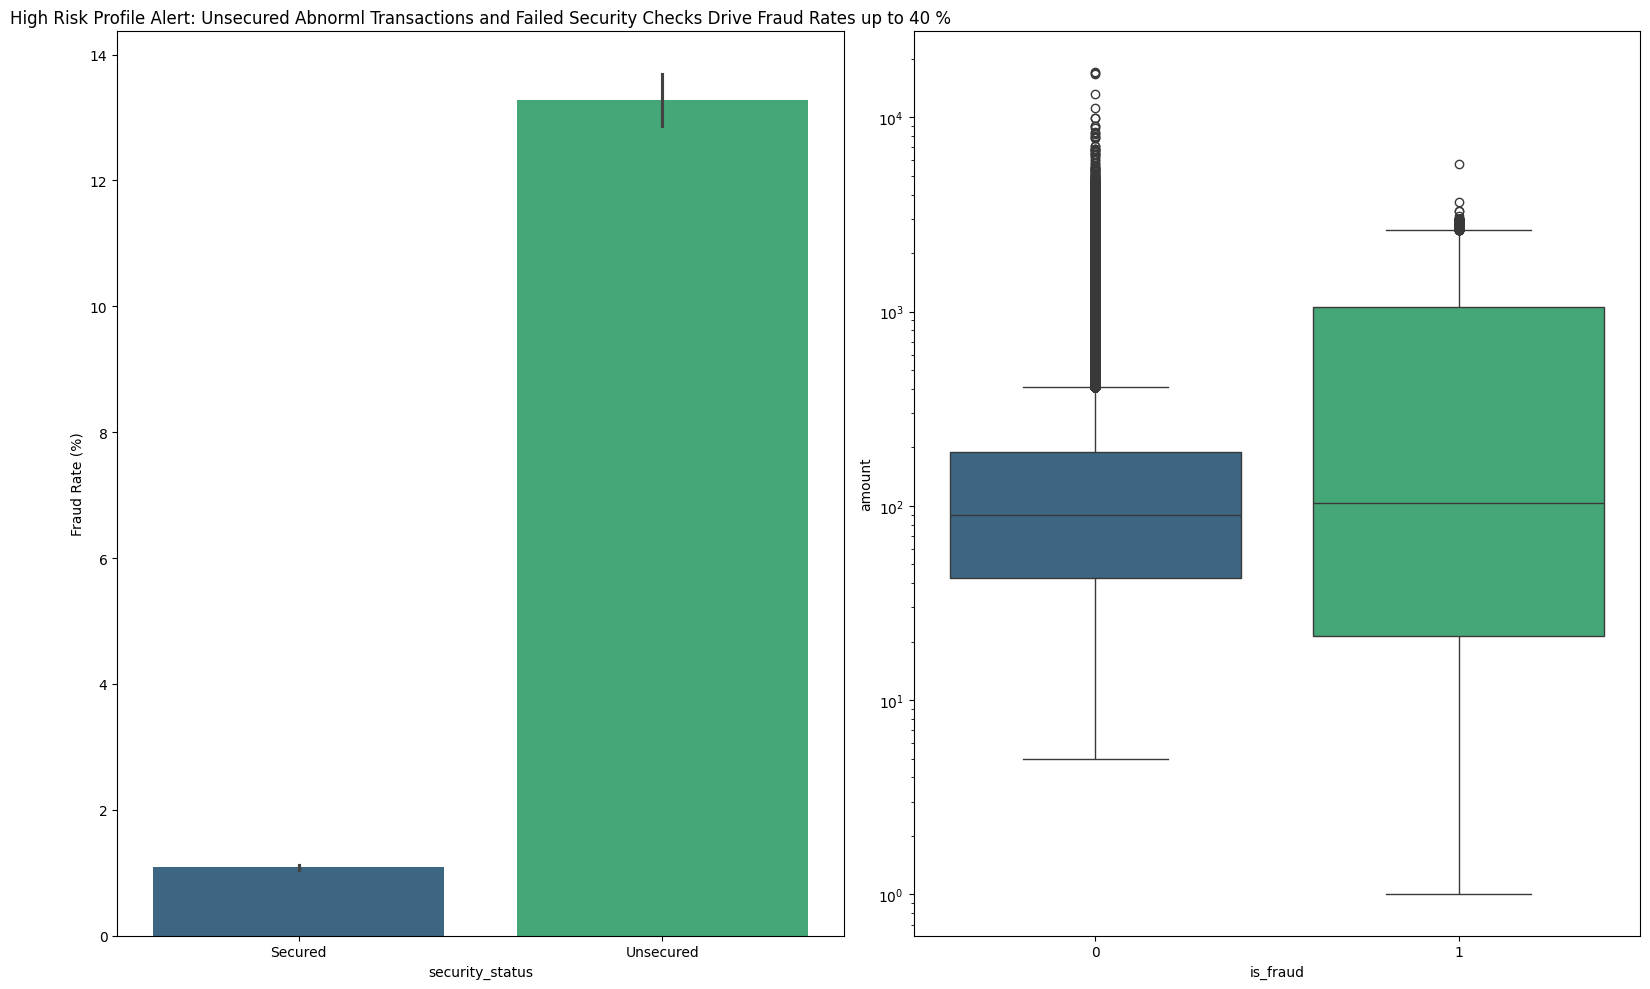

In [22]:
def plot_fraud_analysis(df):
    plt.figure(figsize=(16,10))

    # Graph 1: Barplot for security
    plt.subplot(1,2,1)
    sns.barplot(x = 'security_status', y= 'is_fraud', data= df, estimator=lambda x: sum(x)/len(x) * 100, palette= 'viridis')
    plt.title('High Risk Profile Alert: Unsecured Abnorml Transactions and Failed Security Checks Drive Fraud Rates up to 40 %')
    plt.ylabel('Fraud Rate (%)')

    # Graph 2: Boxplot for amounts
    plt.subplot(1,2,2)
    sns.boxplot(x = 'is_fraud', y = 'amount', data= df, palette= 'viridis')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

plot_fraud_analysis(df)    

In [23]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

def test_security_hypothesis(df):
    """
    Performs a Z-test to compare fraud proportions between secured and unsecured groups.
    """
    # 1. Prepare data groups
    secured = df[df['security_status'] == 'Secured']
    unsecured = df[df['security_status'] == 'Unsecured']
    
    # 2. Get counts of fraud (successes) and total observations (n)
    fraud_counts = [secured['is_fraud'].sum(), unsecured['is_fraud'].sum()]
    total_counts = [len(secured), len(unsecured)]
    
    # 3. Perform Z-test for proportions
    # H1: fraud in secured < fraud in unsecured ('smaller')
    z_stat, p_value = proportions_ztest(count=fraud_counts, nobs=total_counts, alternative='smaller')
    
    # 4. Calculate 95% Confidence Interval for the difference
    ci_low, ci_high = confint_proportions_2indep(
        fraud_counts[0], total_counts[0], 
        fraud_counts[1], total_counts[1], 
        method='wald'
    )
    
    # Results Summary
    print(f"--- Hypothesis Testing Results ---")
    print(f"Z-statistic: {z_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"95% CI for difference: [{ci_low:.4f}, {ci_high:.4f}]")
    
    if p_value < 0.05:
        print("Result: Reject H0. There is a significant difference in fraud rates.")
    else:
        print("Result: Fail to reject H0. No statistically significant difference found.")


test_security_hypothesis(df)

--- Hypothesis Testing Results ---
Z-statistic: -131.3544
P-value: 0.0000
95% CI for difference: [-0.1260, -0.1179]
Result: Reject H0. There is a significant difference in fraud rates.
